The third edition of *Think Stats* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Probability Mass Functions

In the previous chapter we represented distributions using a `Hist` object, which contains a set of quantities and their frequencies -- that is, the number of times each quantity appears.
In this chapter we'll introduce another way to describe a distribution, a probability mass function (PMF).

To represent a PMF, we'll use an object called a `Pmf`, which contains a set of quantities and their probabilities.
We'll use `Pmf` objects to compute the mean and variance of a distribution, and the skewness, which indicates whether it is skewed to the left or right.
Finally, we will explore how a phenomenon called the "inspection paradox" can cause a sample to give a biased view of a distribution.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap03.ipynb).

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'nb_black'

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.5-py3-none-any.whl size=12508 sha256=08d8c0d4b8bb702b85cc11a47f67775d9d90cbcc31606b643b7edec6b8029bcc
  Stored in directory: /root/.cache/pip/wheels/0d/d0/ae/1ad4c7593703e55b2321b23b49d3b0d55261b59d7036d7045b
Successfully built empiricaldist


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## PMFs

A `Pmf` object is like a `Hist` that contains probabilities instead of frequencies.
So one way to make a `Pmf` is to start with a `Hist`.
For example, here's a `Hist` that represents the distribution of values in a short sequence.

In [5]:
from empiricaldist import Hist

hist = Hist.from_seq([1, 2, 2, 3, 5])
hist

,
1,1
2,2
3,1
5,1


The sum of the frequencies is the size of the original sequence.

In [6]:
n = hist.sum()
n

5

If we divide the frequencies by `n`, they represent proportions, rather than counts.

In [7]:
pmf = hist / n
pmf

,
1,0.2
2,0.4
3,0.2
5,0.2


This result indicates that 20% of the values in the sequence are 1, 40% are 2, and so on.

We can also think of these proportions as probabilities in the following sense: if we choose a random value from the original sequence, the probability we choose the value 1 is 0.2, the probability we choose the value 2 is 0.4, and so on.

Because we divided through by `n`, the sum of the probabilities is 1, which means that this distribution is **normalized**.

In [8]:
pmf.sum()

1.0

A normalized `Hist` object represents a **probability mass function** (PMF), so-called because probabilities associated with discrete quantities are also called "probability masses".

The `empiricaldist` library provides a `Pmf` object that represents a probability mass function, so instead of creating a `Hist` object and then normalizing it, we can create a `Pmf` object directly.

In [9]:
from empiricaldist import Pmf

pmf = Pmf.from_seq([1, 2, 2, 3, 5])
pmf

,
1,0.2
2,0.4
3,0.2
5,0.2


The `Pmf` is normalized so the total probability is 1.

In [10]:
pmf.sum()

1.0

`Pmf` and `Hist` objects are similar in many ways.
To look up the probability associated with a value, we can use the bracket operator.

In [11]:
pmf[2]

0.4

Or use parentheses to call the `Pmf` like a function.

In [12]:
pmf(2)

0.4

To assign a probability to a quantity, you have to use the bracket operator.

In [13]:
pmf[2] = 0.2
pmf(2)

0.2

You can modify an existing `Pmf` by incrementing the probability associated with a value:

In [14]:
pmf[2] += 0.3
pmf[2]

0.5

Or you can multiply a probability by a factor:

In [15]:
pmf[2] *= 0.5
pmf[2]

0.25

If you modify a `Pmf`, the result may not be normalized -- that is, the probabilities may no longer add up to 1.

In [16]:
pmf.sum()

0.8500000000000001

The `normalize` method renormalizes the `Pmf` by dividing through by the sum -- and returning the sum.

In [17]:
pmf.normalize()

0.8500000000000001

`Pmf` objects provide a `copy` method so you can make and modify a copy without affecting the original.

In [18]:
pmf.copy()

,
1,0.235294
2,0.294118
3,0.235294
5,0.235294


Like a `Hist` object, a `Pmf` object has a `qs` attribute that accesses the quantities and a `ps` attribute that accesses the probabilities.

It also has a `bar` method that plots the `Pmf` as a bar graph and a `plot` method that plots it as a line graph.

## Summary Statistics

In Section XXX we computed the mean of a sample by adding up the elements and dividing by `n`.
Here's a simple example.

In [19]:
seq = [1, 2, 2, 3, 5]

mean = np.sum(seq) / len(seq)
mean

2.6

Now suppose we compute the PMF of the values in the sequence.

In [20]:
pmf = Pmf.from_seq(seq)

Given the `Pmf`, we can still compute the mean, but the process is different -- we have to multiply the probabilities and quantities and add up the products.

In [21]:
mean = np.sum(pmf.ps * pmf.qs)
mean

2.6

Notice that we *don't* have to divide by `n`, because we already did that when we normalized the `Pmf`.
`Pmf` objects have a `mean` method that does the same thing.

In [22]:
pmf.mean()

2.6

Given a `Pmf`, we can compute the variance by computing the deviation of each quantity from the mean.

In [23]:
deviations = pmf.qs - mean

Then we multiply the squared deviations by the probabilities and add up the products.

In [24]:
var = np.sum(pmf.ps * deviations**2)
var

1.84

The `var` method does the same thing.

In [25]:
pmf.var()

1.84

From the variance, we can compute the standard deviation in the usual way.

In [26]:
np.sqrt(var)

1.3564659966250536

Or the `std` method does the same thing.

In [27]:
pmf.std()

1.3564659966250536

`Pmf` also provides a `mode` method that finds the value with the highest probability.

In [28]:
pmf.mode()

2

We'll see more methods as we go along, but that's enough to get started.

## The Class Size Paradox

As an example of what we can do with `Pmf` objects, let's consider a phenomenon I call "the class size paradox."

At many American colleges and universities, the student-to-faculty ratio is about 10:1.
But students are often surprised that many of their classes have more than 10 students, sometimes a lot more. There are two reasons for the discrepancy:

-   Students typically take 4 or 5 classes per semester, but professors often teach 1 or 2.

-   The number of students who enjoy a small class is small, but the number of students in a large class is large.

The first effect is obvious, at least once it is pointed out; the second is more subtle.
Let's look at an example.
Suppose that a college offers 65 classes in a given semester, and we are given the number of classes in each of the following size ranges.

In [29]:
ranges = pd.interval_range(start=5, end=50, freq=5, closed="left")
ranges.name = "class size"

data = pd.DataFrame(index=ranges)
data["count"] = [8, 8, 14, 4, 6, 12, 8, 3, 2]
data

,count
class size,
"[5, 10)",8
"[10, 15)",8
"[15, 20)",14
"[20, 25)",4
"[25, 30)",6
"[30, 35)",12
"[35, 40)",8
"[40, 45)",3
"[45, 50)",2


The Pandas function `interval_range` makes an `Index` where each label represents a range of values.
The notation `[5, 10)` means that `5` is included in the interval and `10` is not.
Since we don't know the sizes of the classes in each interval, let's assume that all sizes are at the midpoint of the range.

In [30]:
sizes = ranges.left + 2
sizes

Index([7, 12, 17, 22, 27, 32, 37, 42, 47], dtype='int64')

Now let's make a `Pmf` that represents the distribution of class sizes.
Because we know the sizes and their frequencies, we can create a `Pmf` directly, passing as arguments the counts, sizes, and a name.
When we normalize the new `Pmf`, the result is the sum of the counts.

In [31]:
counts = data["count"]
actual_pmf = Pmf(counts, sizes, name="actual")
actual_pmf.normalize()

65

If you ask the college for the average class size, they report the mean of this distribution, which is 23.7.

In [32]:
actual_pmf.mean()

23.692307692307693

But if you survey a group of students, ask them how many students are in their classes, and compute the mean, the average is bigger.
Let's see how much bigger.

The following function takes the actual `Pmf` of class sizes and makes a new `Pmf` that represents the class sizes as seen by students.
The quantities in the two distributions are the same, but the probabilities in the distribution are multiplied by the quantities, because in a class with size `x`, there are `x` students who observe that class.
So the probability of observing a class is proportional to its size.

In [33]:
def bias(pmf, name):
    qs = pmf.qs
    ps = pmf.ps * pmf.qs
    new_pmf = Pmf(ps, pmf.qs, name=name)
    new_pmf.normalize()
    return new_pmf

Now we can compute the biased `Pmf` as observed by students.

In [34]:
observed_pmf = bias(actual_pmf, name="observed")

Here's what the two distributions look like.

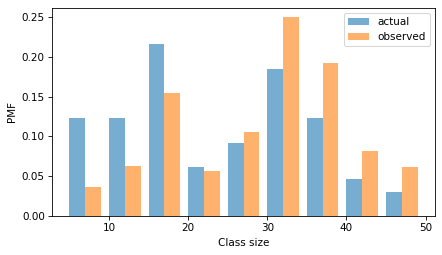

In [35]:
from thinkstats import two_bar_plots

two_bar_plots(actual_pmf, observed_pmf, width=2)
decorate(xlabel="Class size", ylabel="PMF")

In the observed distribution there are fewer small classes and more large ones.
And the biased mean is 29.1, almost 25% higher than the actual mean.

In [36]:
observed_pmf.mean()

29.123376623376622

It is also possible to invert this operation.
Suppose you want to find the distribution of class sizes at a college, but you can't get reliable data.
One option is to choose a random sample of students and ask how many students are in their classes.

The result would be biased for the reasons we've just seen, but you can use it to estimate the actual distribution.
Here's the function that unbiases a `Pmf` by dividing the probabilities by the sizes.

In [37]:
def unbias(pmf, name):
    qs = pmf.qs
    ps = pmf.ps / pmf.qs

    new_pmf = Pmf(ps, pmf.qs, name=name)
    new_pmf.normalize()
    return new_pmf

And here's the result.

In [38]:
debiased_pmf = unbias(observed_pmf, "debiased")
debiased_pmf.mean()

23.692307692307693

The mean of the debiased `Pmf` is the same as the mean of the actual distribution we started with.

If you think this example is interesting, you might like Chapter 2 of *Probably Overthinking It*, which includes this and several other examples of what's called the "inspection paradox".

## NSFG Data

In the previous chapter, we plotted histograms of pregnancy lengths for first babies and others.
But the sizes of the groups are not the same, so we can't compare the histograms directly.
Because PMFs are normalized, we can compare them.
So let's load the NSFG data again and make `Pmf` objects to represent distributions of pregnancy lengths.

The following cells download the data files and install `statadict`, which we need to read the data.

In [39]:
try:
    import statadict
except ImportError:
    !pip install statadict

In [40]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

Downloaded nsfg.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


The `nsfg` module provides a `read_nsfg_groups` function that reads the data, selects rows that represent live births, and partitions live births into first babies and others.
It returns three `DataFrame` objects.

In [41]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

We can use `firsts` and `others` to make a `Pmf` for the pregnancy lengths in each group.

In [42]:
first_pmf = Pmf.from_seq(firsts["prglngth"], name="firsts")
other_pmf = Pmf.from_seq(others["prglngth"], name="others")

Here are the PMFs for first babies and others, plotted as bar graphs.

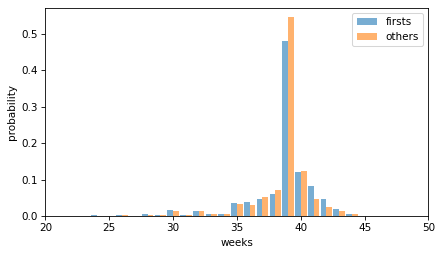

In [43]:
two_bar_plots(first_pmf, other_pmf)
decorate(xlabel="weeks", ylabel="probability", xlim=[20, 50])

By plotting the PMF instead of the histogram, we can compare the two distributions without being misled by the difference in sample size.
Based on this figure, first babies seem to be less likely than others to arrive on time (week 39) and more likely to be late (weeks 41 and 42).

## Other Visualizations

Histograms and PMFs are useful while you are exploring data and trying to identify patterns and relationships.
Once you have an idea what is going on, a good next step is to design a visualization that makes the patterns you have identified as clear as possible.

In the NSFG data, the biggest differences in the distributions are near the mode.
So it makes sense to zoom in on that part of the graph, and select data from weeks 35 to 46.

When we call a `Pmf` object like a function, we can look up a sequence of quantities and get a sequence of probabilities.

In [44]:
weeks = range(35, 46)
first_pmf(weeks)

array([0.03602991, 0.03897575, 0.04713347, 0.06163608, 0.4790392 ,
       0.12145932, 0.08157716, 0.04645366, 0.01971448, 0.00521187,
       0.00135962])

In [45]:
other_pmf(weeks)

array([0.03210137, 0.03146779, 0.05216473, 0.07074974, 0.54466737,
       0.12249208, 0.04794087, 0.02597677, 0.01288279, 0.00485744,
       0.00084477])

So we can compute the differences in the probabilities like this.

In [46]:
diffs = first_pmf(weeks) - other_pmf(weeks)
diffs

array([ 0.00392854,  0.00750796, -0.00503126, -0.00911366, -0.06562817,
       -0.00103276,  0.03363629,  0.02047689,  0.00683169,  0.00035443,
        0.00051485])

Here's what they look like, multiplied by 100 to express the differences in percentage points.

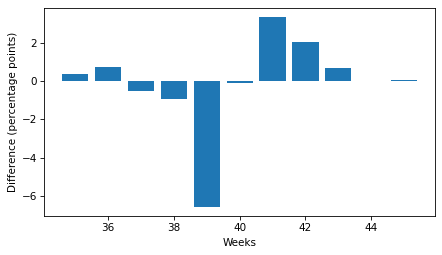

In [47]:
plt.bar(weeks, diffs * 100)
decorate(xlabel="Weeks", ylabel="Difference (percentage points)")

This figure makes the pattern clearer: first babies are less likely to be born in week 39, and somewhat more likely to be born in weeks 41 and 42.

For now we can't be sure this effect is real -- it might be due to random variation.
We'll revisit that question in Chapter xxx.

## Glossary

There are not as many new terms in this chapter as in the previous chapters.

-   **normalized:** A set of probabilities are normalized if they add up to 1.

-   **probability mass function (PMF)**: A function that represents a distribution by mapping each quantity to its probability.

## Exercises

For the exercises in this chapter, we'll use the NSFG respondent file, which contains one row for each respondent.
Instructions for downloading the data are in the notebook for this chapter.

In [48]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

Downloaded 2002FemResp.dct
Downloaded 2002FemResp.dat.gz


The codebook for this dataset is at <https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NSFG/Cycle6Codebook-Female.pdf>.

The `nsfg.py` module provides a function that reads the respondent file and returns a `DataFrame`.

In [49]:
from nsfg import read_fem_resp

resp = read_fem_resp()
resp.shape

(7643, 3092)

This `DataFrame` contains 7643 rows and 3092 columns.

### Exercise

Select the column `numbabes`, which records the "number of babies born alive" to each respondent.
Make a `Hist` object and display the frequencies of the values in this column.
Check that they are consistent with the frequencies in the code book.
Are there any special values that should be replaced with `NaN`?

Then make a `Pmf` object and plot it as a bar graph. Is the distribution symmetric, skewed to the left, or skewed to the right?

In [67]:
# Solution goes here
numbabes2 = Hist.from_seq(resp["numbabes"].replace(97, np.nan))
numbabes2


,
numbabes,
0.0,3229
1.0,1519
2.0,1603
3.0,828
4.0,309
5.0,95
6.0,29
7.0,15
8.0,8


In [82]:
# Solution goes here
#pmf1 = Pmf.from_seq(numbabes2)
#pmf = numbabes2/len(numbabes2)

pmf1 = Pmf.from_seq(resp["numbabes"].replace(97, np.nan))
pmf1


,
numbabes,
0.0,0.422533
1.0,0.198770
2.0,0.209762
3.0,0.108349
4.0,0.040434
5.0,0.012431
6.0,0.003795
7.0,0.001963
8.0,0.001047


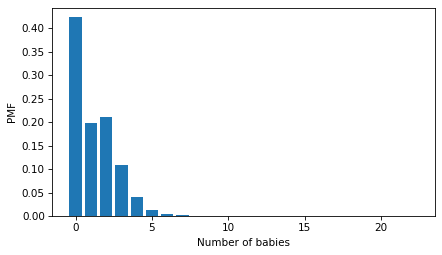

In [83]:
pmf1.bar()
decorate(xlabel="Number of babies", ylabel="PMF")

In [53]:
# Solution goes here

### Exercise

In the same way that the mean identifies a central point in a distribution, and variance quantifies its spread, there is another statistic, called **skewness**, that is intended to indicate whether a distribution is skewed to the left or right.

Given a sample, we can compute the skewness by computing the sum of the cubed deviations and dividing by the standard deviation cubed.
For example, here's how we compute the skewness of `numbabes`.


In [87]:
numbabes = resp["numbabes"].replace(97, np.nan)
numbabes

,numbabes
0,4.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
7638,0.0
7639,0.0
7640,0.0
7641,0.0


In [55]:
deviations = numbabes - numbabes.mean()
skewness = np.mean(deviations**3) / numbabes.std(ddof=0) ** 3
skewness

1.7018914266755378

In general, a positive value indicates that a distribution is skewed to the right, and a negative value indicates that it is skewed to the left.

If you are given a `Pmf`, rather than a sequence of values, you can compute skewness like this:

1. Compute the deviation of each quantity in the `Pmf` from the mean.

2. Cube the deviations, multiply by the probabilities in the `Pmf`, and add up the products.

3. Divide the sum by the standard deviation cubed.

Write a function called `pmf_skewness` that takes a `Pmf` object and returns its skewness.

In [96]:
# Solution goes here
def pmf_skewness(pmf, name):
    ps = pmf.ps
    deviations2 = ps - ps.mean()
    skewness2 = np.mean(deviations2**3) / ps.std(ddof=0) ** 3
    return skewness2


Use your function and the `Pmf` of `numbabes` to compute skewness, and confirm you get the same result.

In [97]:
# Solution goes here
pmf_skewness(pmf1, "skew2")

1.7140078063805184

### Exercise

Something like the class size paradox appears if you survey children and ask how many children are in their family.
Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

From `resp`, select `numkdhh`, which records the number of children under 18 in each respondent's household.
Make a `Pmf` of the values in this column.

Use the `bias` function to compute the distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

In [58]:
# Solution goes here

In [59]:
# Solution goes here

In [60]:
# Solution goes here

In [61]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)